## This dataset was found [link](https://courses.analyticsvidhya.com) and it's part of a competition.
#### first part is to load modules relevant to our analysis

* Create a model that is capable of predicting the chance of an employee getting promoted.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline


pd.set_option('display.max_columns', 500) #fixing the number of rows and columns to be displayed
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings(action="ignore")

### Loading the datasets, we have separate the data and testing set

In [2]:
train = pd.read_csv("../input/train_LZdllcl.csv")
test = pd.read_csv("../input/test_2umaH9m.csv")

train.set_index("employee_id", inplace = True)

test.set_index("employee_id", inplace = True)

In [3]:
train.head() #taking a look at the first entries

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


* merging both datasets in order to make it easier to change the whole dataset, gonna create a new column called source

In [4]:
##Merging the train and test dataset in order to have more data to train our model.

train['source']='train' #creating a label for the training and testing set
test['source']='test'

data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape) #printing the shape

(54808, 14) (23490, 13) (78298, 14)


In [5]:
#checking for null values:
data.isnull().sum()

KPIs_met >80%               0
age                         0
avg_training_score          0
awards_won?                 0
department                  0
education                3443
gender                      0
is_promoted             23490
length_of_service           0
no_of_trainings             0
previous_year_rating     5936
recruitment_channel         0
region                      0
source                      0
dtype: int64

#### all is_promoted null values come from the test dataset, those are not a problem as they are the values that we want to predict

In [6]:
## gonna quickly change the names of KPI and Awards won, making it easier to read
#changing those to better names
data.rename(columns={"KPIs_met >80%":"KPI"},inplace=True)
data.rename(columns={"awards_won?":"awards_won"},inplace=True)

In [7]:
data.apply(lambda x: len(x.unique())) # let's take a look at how many unique values does it have

KPI                      2
age                     41
avg_training_score      61
awards_won               2
department               9
education                4
gender                   2
is_promoted              3
length_of_service       35
no_of_trainings         10
previous_year_rating     6
recruitment_channel      3
region                  34
source                   2
dtype: int64

## Quickly describe what are those parameters:
* KPI - KPI is met > 80% - A boolean value telling us whether or not a given employee has met the KPI
* age - Age of a given employee
* avg_training_score - The average training score
* awards_won - boolean value, it has won or not
* department - 9 different departaments, categorical column
* education - categorical column
* gender - gonna change this categorical categorie, 0 female / 1 men
* is_promoted - boolean value, has it got a promotion or not?
* length_of_service - amount of time working for the company
* no_of_trainings - number of trainings
* previous_year_rating - rating given in the previous year, the higher the better
* recruitment_channel - categorical category
* region - different regions in this company

filtering and showing all different categorical variables

In [8]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['gender','source']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible department
Sales & Marketing    24155
Operations           16112
Procurement          10158
Technology           10149
Analytics             7671
Finance               3627
HR                    3503
Legal                 1484
R&D                   1439
Name: department, dtype: int64

Frequency of Categories for varible education
Bachelor's          52247
Master's & above    21429
Below Secondary      1179
Name: education, dtype: int64

Frequency of Categories for varible recruitment_channel
other       43524
sourcing    33181
referred     1593
Name: recruitment_channel, dtype: int64

Frequency of Categories for varible region
region_2     17642
region_22     9167
region_7      6825
region_15     3938
region_13     3815
region_26     3271
region_31     2779
region_4      2478
region_27     2369
region_16     2055
region_28     1913
region_11     1886
region_23     1691
region_29     1408
region_32     1378
region_19     1284
region_14     1177
regio

#### the gender categorie and education is easily mapped into numerical ones, let's do it:

In [9]:
data['gender'] = data['gender'].map( {'f': 0, 'm': 1} ).astype(int) #mapping gender

#### same thing for the education categorie, mapping it into 3 different categories.

In [10]:
data["education"].fillna('Bachelor\'s',inplace=True) #filling in all the null values before mapping it with the most frequent value
data['education'] = data['education'].map( {'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2} ).astype(int) #mapping gender

In [11]:
data.isnull().sum() #Previous year rating is gonna be imput afterwards with pipelines, the mediam value

KPI                         0
age                         0
avg_training_score          0
awards_won                  0
department                  0
education                   0
gender                      0
is_promoted             23490
length_of_service           0
no_of_trainings             0
previous_year_rating     5936
recruitment_channel         0
region                      0
source                      0
dtype: int64

***

## Ploting a heating map showing the pearson's correlation
* dropping the categorical features as it won't work for our pearson's correlation

Text(0.5, 1.0, 'Pearsons Correlation Factors Heat Map')

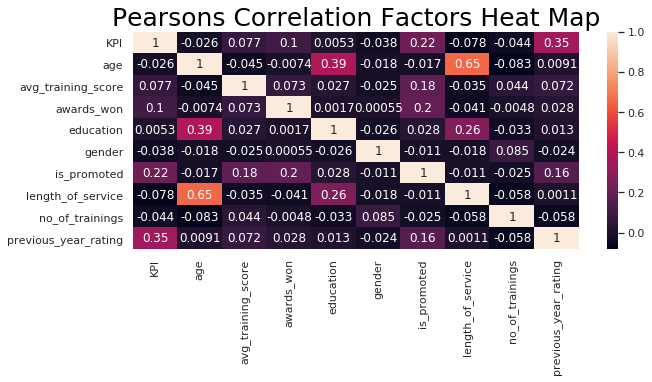

In [12]:
corr = data.drop(['source','recruitment_channel','department','region'],axis=1).astype(float).corr() #saving the correlation for later use
ax = sns.set(rc={'figure.figsize':(10,4)})
sns.heatmap(corr, annot=True).set_title('Pearsons Correlation Factors Heat Map', color='black', size='25')

* KPI, previous year rating and awards won are posively correlated to promotion

Text(0.5, 1.0, 'Age distribution')

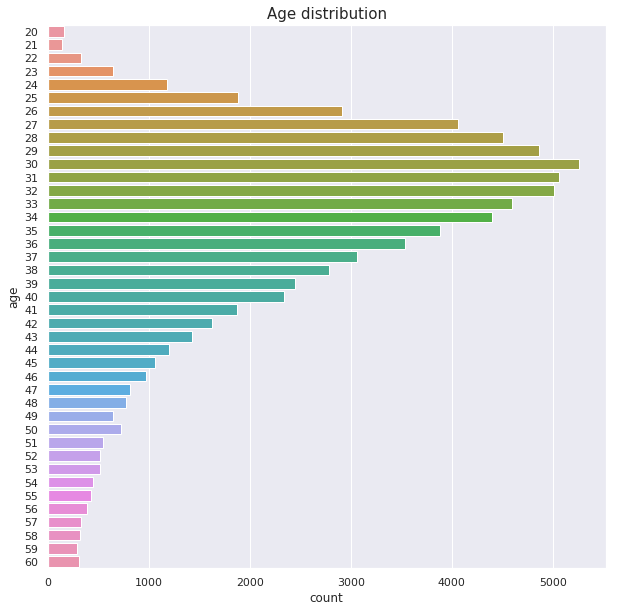

In [13]:
sns.set(rc={'figure.figsize':(10,10)}) #setting the size of the figure to make it easier to read.
sns.countplot(y=data["age"]).set_title("Age distribution", fontsize=15) #plotting it horizontally to make it easier to read

** The age distribution is a normal distribution, the peak of the distribution is 32 years **

* it would be a good idea to map age and create 5 differente values for it, according to the distribution above:
* **<=26 : 0**
* **> 27  < 35 : 1**
* **> 35  < 50 : 2**
* **> 50 : 3**

In [14]:
data.loc[data['age'] <= 26, 'age'] = 0
data.loc[(data['age'] > 26) & (data['age'] <= 35), 'age'] = 1
data.loc[(data['age'] > 35) & (data['age'] <= 50), 'age'] = 2
data.loc[data['age'] > 50, 'age'] = 3

Text(0.5, 1.0, 'Distribution of age after mapping')

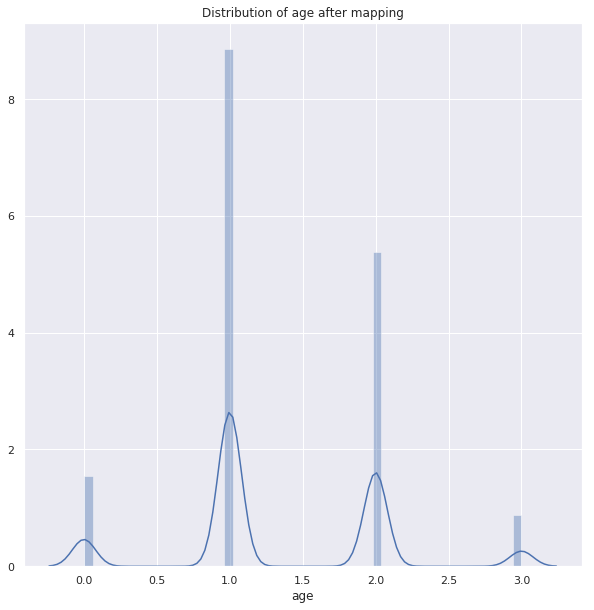

In [15]:
sns.distplot(data["age"]).set_title("Distribution of age after mapping")

Text(0.5, 1.0, 'Departament distribution')

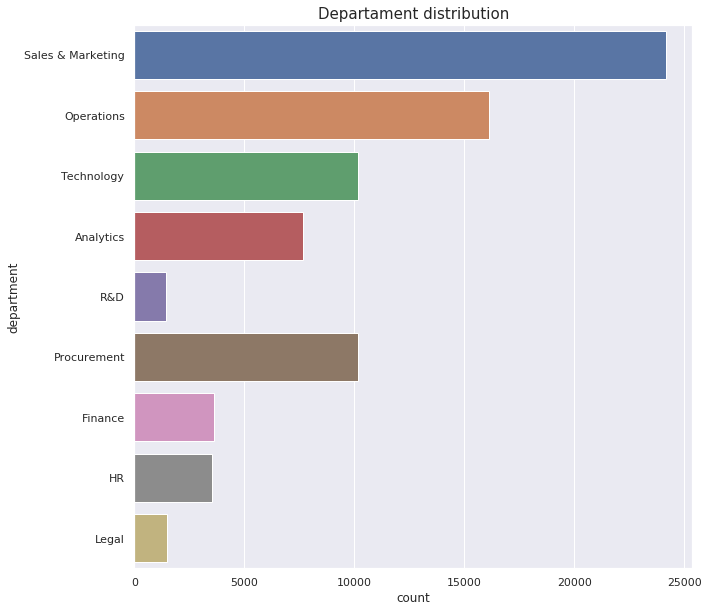

In [16]:
sns.set(rc={'figure.figsize':(10,10)}) #setting the size of the figure to make it easier to read.
sns.countplot(y=data["department"]).set_title("Departament distribution", fontsize=15) #plotting it horizontally to make it easier to read

* creating a pivot table to help us see the distribution of all departaments and lenght of service by sex

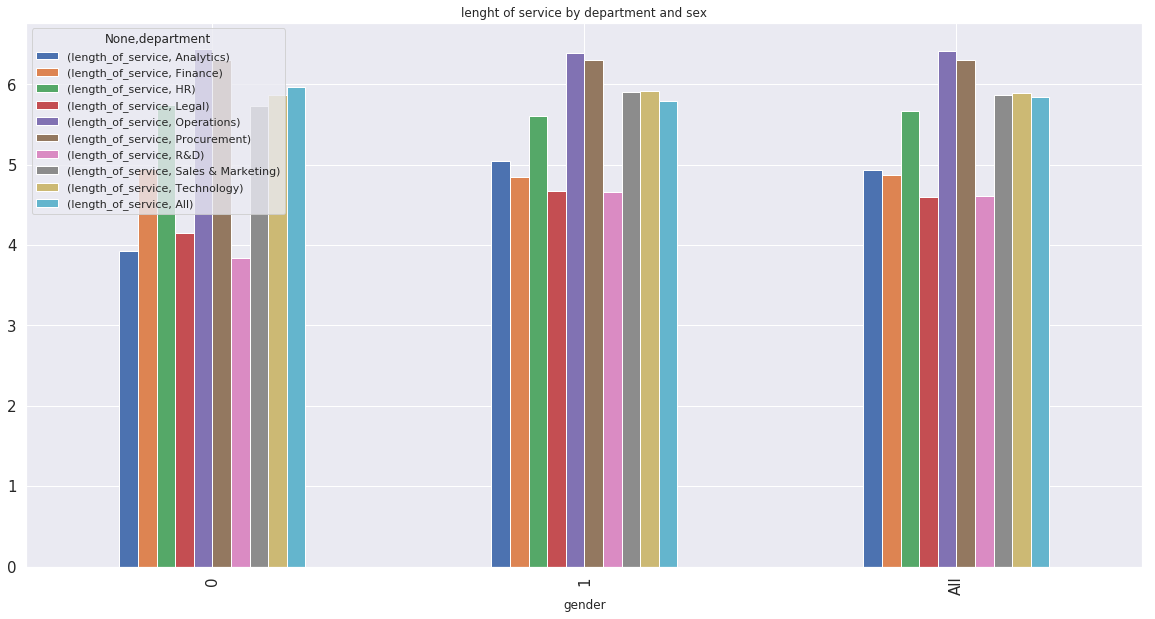

In [17]:
data_by_sex = data.pivot_table(columns=["department"], index=["gender"],values=["length_of_service"],
                               fill_value=0,margins=True,dropna=True)
data_by_sex.plot(kind="bar", stacked=False, figsize=(20,10), title="lenght of service by department and sex",fontsize=15)

* as can be seen, the lenght of service is pretty uniforme accross all the departaments

### splitting our dataset into train and test again, using the split columns create previously
#### Creating a train_labels with our target as well
##### It's also advisable to create a validation set, 20% of the training set

In [18]:
from sklearn.model_selection import train_test_split #importing the relevant module
#recreating the training set and testing set with all the modifications that has been made.
## before anything, however, I am gonna drop region and recruitment channel, as it is only make training slower
data.drop(['recruitment_channel','region'], axis=1, inplace=True)
train = data[data['source'] == 'train'].copy()
test = data[data['source'] == 'test'].copy()

#splitting the data and creating the labels
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)

train_labels = train_set["is_promoted"].copy() #creating our Y_train
train_set.drop(['source','is_promoted'], axis=1, inplace=True)

test_set_labels = test_set["is_promoted"].copy() #creating our Y_test
test_set.drop(['source','is_promoted'], axis=1, inplace=True)


test.drop(['source','is_promoted'], axis=1, inplace=True)

In [19]:
print(train.shape, train_set.shape, test_set.shape, test.shape) #printing the shape of the newly created training and testing set

(54808, 12) (43846, 10) (10962, 10) (23490, 10)


***

## Creating the classes and pipelines to scale and imput the data for our models

In [104]:
#let's use the Imputer to fill the NAN values with the median value
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#numerical values
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#categorical values and numerical values, gonna use OneHotEnconder for the categorical.
num_attribs = train_set.select_dtypes(exclude=['object']) #selecting all the numerical data 
cat_attribs = train_set.select_dtypes(exclude=['int64','float64']) #selecting non numerical data

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(num_attribs)),
        ("cat", OrdinalEncoder(), list(cat_attribs)),
        #("cat", OneHotEncoder(), list(cat_attribs)), #this is a better option for datasets where the ordinal enconder would not capture the correlation
        
    ]) 


***

## Creating a function to test our models and cross validate it
### Accuracy, precision, recall and F1 score are going to be presented for both the prediction and cross validation
#### It has also the pipeline option, so the function impute the data, scale and transforme then it fit on the model and apply cross validation

In [100]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score
import time #implementing in this function the time spent on training the model
from sklearn.model_selection import cross_val_score

#Generic function for making a classification model and accessing performance:
def classification_model(model, X_train, y_train, predict_only = False):
    #Fit the model:
    time_start = time.perf_counter() #start counting the time
    
    if not predict_only: #optional parameter of our function, whether we want our model to be trained, or if we had trained it previously and want to see predictions only
        model.fit(X_train,y_train)

    #predicting using the model that has been trained above
    train_predictions = model.predict(X_train)
    
    #measuring each different score
    accuracy = accuracy_score(y_train, train_predictions)
    precision = precision_score(y_train, train_predictions)
    recall = recall_score(y_train, train_predictions)
    f1 = f1_score(y_train, train_predictions)
    
    print("-Model results, in percentage-")
    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("Precision: %.2f%%" % (precision * 100))
    print("Recall: %.2f%%" % (recall * 100))
    print("F1 score: %.2f%%" % (f1 * 100))
    cr_val_precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
    cr_val_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cr_val_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
    cr_val_roc_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cr_val_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    
    time_end = time.perf_counter() #end of counting the time
    
    total_time = time_end-time_start #total time spent during training and cross_validation
    print("Cross Validation Score(scoring: precision): %.2f%%" % (np.mean(cr_val_precision) * 100))
    print("Cross Validation Score(scoring: accuracy): %.2f%%" % (np.mean(cr_val_accuracy) * 100))
    print("Cross Validation Score(scoring: recall): %.2f%%" % (np.mean(cr_val_recall) * 100))
    print("Cross Validation Score(scoring: roc_auc): %.2f%%" % (np.mean(cr_val_roc_auc) * 100))
    print("Cross Validation Score(scoring: f1): %.2f%%" % (np.mean(cr_val_f1) * 100))
    print("Amount of time spent during training the model and cross validation: %4.3f seconds" % (total_time))

##### Finally, training different models and measuring how they perform using different metrics

In [101]:
train_prepared = full_pipeline.fit_transform(train_set)

In [105]:
#ok, nice, now that we have our data prepared, let's start testing some models
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="liblinear")
classification_model(log_reg, train_prepared,train_labels)

-Model results, in percentage-
Accuracy: 91.67%
Precision: 62.76%
Recall: 7.13%
F1 score: 12.80%
Cross Validation Score(scoring: precision): 62.55%
Cross Validation Score(scoring: accuracy): 91.67%
Cross Validation Score(scoring: recall): 7.10%
Cross Validation Score(scoring: roc_auc): 80.38%
Cross Validation Score(scoring: f1): 88.52%
Amount of time spent during training the model and cross validation: 4.598 seconds


In [106]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

classification_model(sgd_clf, train_prepared, train_labels)

-Model results, in percentage-
Accuracy: 91.42%
Precision: 25.00%
Recall: 0.03%
F1 score: 0.05%
Cross Validation Score(scoring: precision): 38.89%
Cross Validation Score(scoring: accuracy): 89.91%
Cross Validation Score(scoring: recall): 12.93%
Cross Validation Score(scoring: roc_auc): 70.01%
Cross Validation Score(scoring: f1): 87.82%
Amount of time spent during training the model and cross validation: 1.294 seconds


In [107]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(n_estimators=200)
classification_model(rand_forest,train_prepared, train_labels) 

-Model results, in percentage-
Accuracy: 97.91%
Precision: 97.15%
Recall: 77.87%
F1 score: 86.45%
Cross Validation Score(scoring: precision): 61.77%
Cross Validation Score(scoring: accuracy): 92.59%
Cross Validation Score(scoring: recall): 36.22%
Cross Validation Score(scoring: roc_auc): 86.12%
Cross Validation Score(scoring: f1): 91.71%
Amount of time spent during training the model and cross validation: 193.925 seconds


## Gonna create a function to see different feature importance according to different models
#### using the Random forest model to plot feature importances.

In [109]:
def plot_feature_importances(model):
    # Plot feature importance
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    plt.figure(figsize=(20, 20))
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, train_set.columns[sorted_idx], fontsize=15)
    plt.xlabel('Relative Importance', fontsize=30)
    plt.title('Variable Importance')

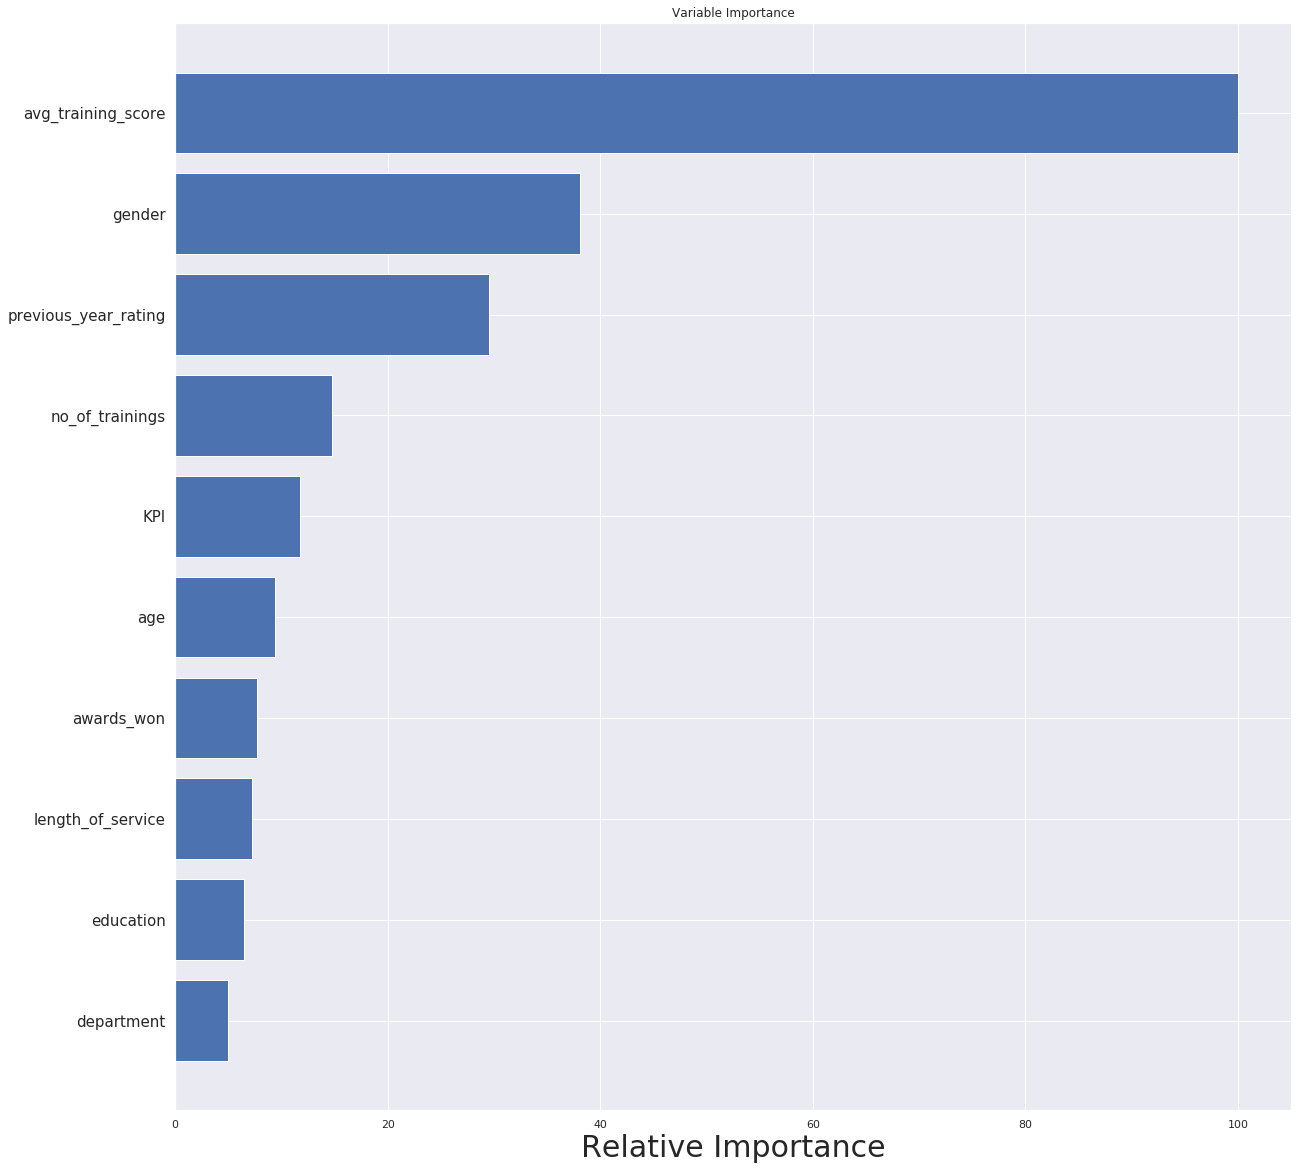

In [110]:
plot_feature_importances(rand_forest) #PLOTING FEATURES IMPORTANCES RELATIVE TO RANDOM FOREST

* take a close look at the random forest features importance, average trainig score is the highest feature correlated to is_promoted? KPI is met was fairly higher correlated when we plotted the pearson's correlation
* Notice how all the models above are not really generalizing well enough, keep going on

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.09)
classification_model(gbc_model,train_prepared, train_labels)

-Model results, in percentage-
Accuracy: 94.49%
Precision: 95.22%
Recall: 37.61%
F1 score: 53.92%


** plot the features importance and see what we got **

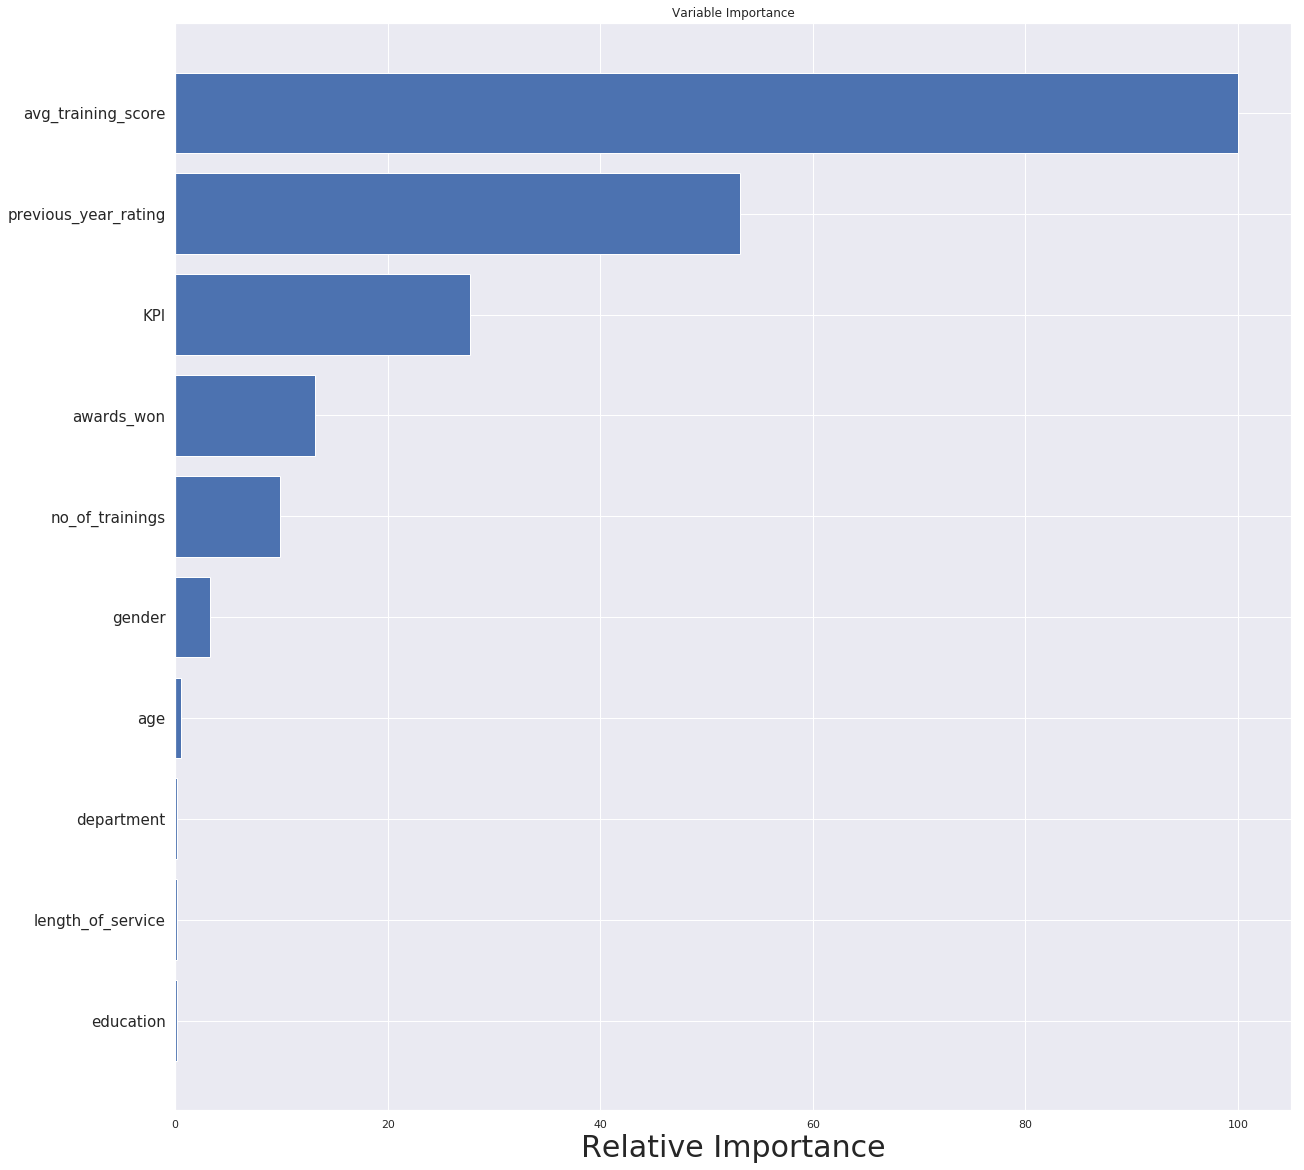

In [45]:
plot_feature_importances(gbc_model)#PLOTING FEATURES IMPORTANCES RELATIVE TO GRADIENT BOOSTING

* compared to what we got for the random forest, this relative importance makes way more sense
* recall is relatively low for all the models so far, remember that we have the recall X precision tradeoff, in the case of this dataset, we are getting good precision and accuracy but the model is getting a significant lower recall, that means, the model is failling to identify all relevant instances, F1 score, as would be expected, is also low. As it is defined by precision/recall

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.1, random_state=42)

classification_model(ada_clf,train_prepared, train_labels)

-Model results, in percentage-
Accuracy: 92.26%
Precision: 81.20%
Recall: 12.63%
F1 score: 21.86%
Cross Validation Score(scoring: accuracy): 92.23%
Cross Validation Score(scoring: recall): 12.58%
Cross Validation Score(scoring: roc_auc): 82.84%
Cross Validation Score(scoring: f1): 89.55%
Amount of time spent during training the model and cross validation: 94.330 seconds


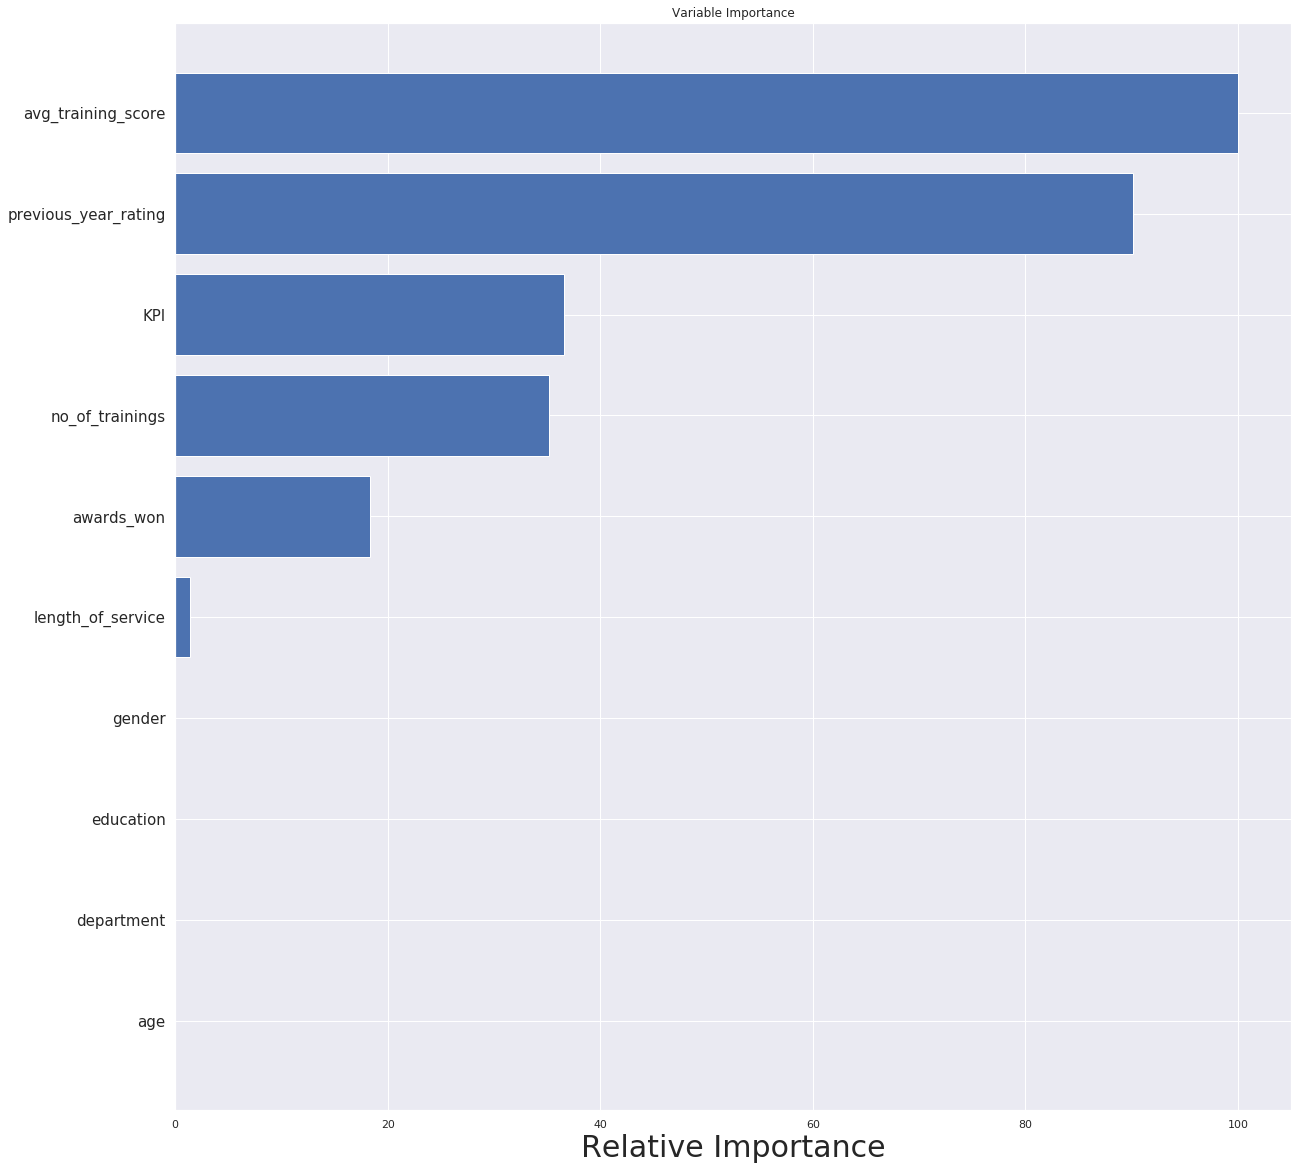

In [44]:
plot_feature_importances(ada_clf)#PLOTING FEATURES IMPORTANCES RELATIVE TO ADA BOOSTING

Selecting only those features and seeing how the model peform:
* KPI
* avg_training_score 
* awards_won
* length_of_service
* no_of_trainings
* previous_year_rating   
* education
* gender

In [50]:
train_prepared_some_features = num_pipeline.fit_transform(train_set[['avg_training_score','length_of_service',
                                                                      'no_of_trainings','previous_year_rating',
                                                                      'KPI','awards_won','gender','education'
                                                                     ]])

In [95]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(learning_rate=0.09, n_estimators=1000, max_depth=4, min_child_weight=15, 
                      gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, 
                        objective= 'binary:logistic',scale_pos_weight=4,seed=29)

classification_model(xgb_model,train_prepared_some_features,train_labels) #training with only some features selected

-Model results, in percentage-
Accuracy: 89.72%
Precision: 41.44%
Recall: 48.03%
F1 score: 44.49%
Cross Validation Score(scoring: accuracy): 87.81%
Cross Validation Score(scoring: recall): 38.75%
Cross Validation Score(scoring: roc_auc): 83.15%
Cross Validation Score(scoring: f1): 88.30%
Amount of time spent during training the model and cross validation: 230.442 seconds


In [97]:
classification_model(xgb_model, train_prepared, train_labels) #training with all features

-Model results, in percentage-
Accuracy: 92.11%
Precision: 53.37%
Recall: 63.14%
F1 score: 57.85%
Cross Validation Score(scoring: accuracy): 90.27%
Cross Validation Score(scoring: recall): 52.58%
Cross Validation Score(scoring: roc_auc): 89.99%
Cross Validation Score(scoring: f1): 90.64%
Amount of time spent during training the model and cross validation: 226.742 seconds


* and what about the lgbm?

In [63]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(learning_rate=0.3, n_estimators=200, max_depth=4, min_child_weight=15, 
                      gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, 
                        scale_pos_weight=4,seed=29) # same parameters as I used for XGBoost

In [64]:
classification_model(lgb_model, train_prepared, train_labels)

-Model results, in percentage-
Accuracy: 93.77%
Precision: 68.64%
Recall: 50.35%
F1 score: 58.09%
Cross Validation Score(scoring: accuracy): 92.58%
Cross Validation Score(scoring: recall): 45.32%
Cross Validation Score(scoring: roc_auc): 90.04%
Cross Validation Score(scoring: f1): 92.14%
Amount of time spent during training the model and cross validation: 9.610 seconds


* LGBM is 3 times faster than the XGBoost, and it's giving us the same score. It's a really bad score, btw
* XGBoost is giving us a fairly better score training with all features, however, when we train with only some features selected, the model isn't improving.
* it would be a good idea searching for parameters in order to increase F1 score and thereby improve our model. Let's use the grid_search
I am gonna be using LGB instead of XGBoost

In [79]:
from sklearn.model_selection import GridSearchCV
params = {
  'min_child_weight':[6,10,15],
  #'max_depth': range(3,10,2),
  'n_estimators':[600,900,1000],
  'scale_pos_weight':[1,2,3,4],
    'learning_rate': [0.005,0.05,0.09,0.1]
  #'colsample_bytree':[0.7,0.8], 
  #'subsample':[0.7,0.8],
  #'gamma':[0,0.2.0.4]
    
}
grid_search = GridSearchCV(estimator = lgb_model,
param_grid = params, scoring='recall',n_jobs=4,iid=False, verbose=10, cv=5)

In [80]:
grid_search.fit(train_prepared,train_labels)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  5.9min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        gamma=0.4, importance_type='split', learning_rate=0.3, max_depth=4,
        min_child_samples=20, min_child_weight=7, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, nthread=4, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=3, seed=29, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 10, 15], 'n_estimators': [600, 900, 1000], 'scale_pos_weight': [1, 2, 3, 4], 'learning_rate': [0.005, 0.05, 0.09, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

** Nice, now having finished our grid_search, it's time to see whether it's going to improve our previous score or not **

* but first, let's take a look at what estimator it has found with which parameters

In [90]:
grid_search.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        gamma=0.4, importance_type='split', learning_rate=0.09,
        max_depth=4, min_child_samples=20, min_child_weight=15,
        min_split_gain=0.0, n_estimators=1000, n_jobs=-1, nthread=4,
        num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=4, seed=29, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [91]:
grid_search.best_params_

{'learning_rate': 0.09,
 'min_child_weight': 15,
 'n_estimators': 1000,
 'scale_pos_weight': 4}

In [92]:
final_model_lgb = grid_search.best_estimator_ #creating a variable with our best model

* let's see how our model is doing

In [86]:
classification_model(final_model_lgb, train_prepared, train_labels, predict_only=True)

-Model results, in percentage-
Accuracy: 92.17%
Precision: 53.92%
Recall: 59.68%
F1 score: 56.65%
Cross Validation Score(scoring: accuracy): 90.59%
Cross Validation Score(scoring: recall): 52.61%
Cross Validation Score(scoring: roc_auc): 90.10%
Cross Validation Score(scoring: f1): 90.88%
Amount of time spent during training the model and cross validation: 41.368 seconds


#### Now that we have prepared our model, tunning it with the grid_search, which, btw, hasn't resulted in a impressive result, but, nevertheless, we are going to see how it's performing in our test validation set

In [88]:
test_val_prepared = full_pipeline.fit_transform(test_set)


In [93]:
classification_model(final_model_lgb, test_val_prepared, test_set_labels, predict_only=True)

-Model results, in percentage-
Accuracy: 93.14%
Precision: 56.58%
Recall: 73.90%
F1 score: 64.09%
Cross Validation Score(scoring: accuracy): 89.56%
Cross Validation Score(scoring: recall): 49.67%
Cross Validation Score(scoring: roc_auc): 88.67%
Cross Validation Score(scoring: f1): 90.09%
Amount of time spent during training the model and cross validation: 16.817 seconds


** recall and f1 score is doing fairly bad, I am not really happy with this LGB model, I am gonna try random forest and XGBoost in our test_validation model to see how it performs**

In [98]:
classification_model(xgb_model, test_val_prepared, test_set_labels, predict_only=True)

-Model results, in percentage-
Accuracy: 90.50%
Precision: 43.80%
Recall: 51.76%
F1 score: 47.45%
Cross Validation Score(scoring: accuracy): 89.38%
Cross Validation Score(scoring: recall): 49.45%
Cross Validation Score(scoring: roc_auc): 88.47%
Cross Validation Score(scoring: f1): 89.95%
Amount of time spent during training the model and cross validation: 57.990 seconds


* LGBM and XBM are both performing quite similar to each other.

#### I would love to improve score a bit further